# 3D CNN for Lung Cancer Detection

First import the libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import os
from random import shuffle
import matplotlib.pyplot as plt

## Splitting training and validation set
### One-hot encoding
Performing one-hot encoding for labels (1D array):

In [2]:
def one_hot_encode(labels):
    one_hot = np.zeros((len(labels), 2))
    one_hot[np.arange(len(labels)), labels] = 1
    
    return one_hot

sample_labels = [1, 0, 1]
one_hot_sample_labels = one_hot_encode(sample_labels)
print(one_hot_sample_labels)

[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


### Saving Data

In [3]:
preprocessed_data_folder = './stage1_preprocessed/'

data_shape = [250, 350, 350]
train_size = 0.8 # relative size of train set
batch_size = 5 # divide set into batches to prevent machine from running out of memory

In [4]:
patients = os.listdir(preprocessed_data_folder)
shuffle(patients) # randomize the order of data

# initialization
train_batches = []
valid_batches = []
current_train_batch = []
current_valid_batch = []

train_data_size = 0
valid_data_size = 0

for i in range(len(patients)):  
    if patients[i].startswith('.'): continue # ignore hidden files
    #patient_data = 
    if np.load(preprocessed_data_folder + patients[i])['set'] == 'test': continue # ignore test data
    
    if i < int(len(patients) * train_size): # train set
        current_train_batch.append(patients[i])
        
        #  if current train batch is full
        if (len(current_train_batch) == batch_size): 
            train_batches.append(current_train_batch)
            train_data_size += batch_size
            current_train_batch = []
            
    else: # validation set
        current_valid_batch.append(patients[i])
        
        #  if current validation batch is full
        if (len(current_valid_batch) == batch_size): 
            valid_batches.append(current_valid_batch)
            valid_data_size += batch_size
            current_valid_batch = []

# save the remaining training and validation data set
if len(current_train_batch) != 0:
    train_data_size += len(current_train_batch)
    # pad zeros to make its size equal to batch_size
    while (len(current_train_batch) != batch_size):
        current_train_batch.append(0)
    train_batches.append(current_train_batch)
    current_train_batch = []

if len(current_valid_batch) != 0:
    valid_data_size += len(current_valid_batch)
    while (len(current_valid_batch) != batch_size):
        current_valid_batch.append(0)
    valid_batches.append(current_valid_batch)
    current_valid_batch = []

train_batches = np.array(train_batches)
valid_batches = np.array(valid_batches)

print('Total data size: {:d}, Training data size: {:d}, Validation data size: {:d} '.format(
    train_data_size + valid_data_size, train_data_size, valid_data_size))
print('Number of train batches: {:d}, Number of validation batches: {:d}'.format(
    train_batches.shape[0], valid_batches.shape[0]))

Total data size: 1396, Training data size: 1112, Validation data size: 284 
Number of train batches: 223, Number of validation batches: 57


### Loading Data

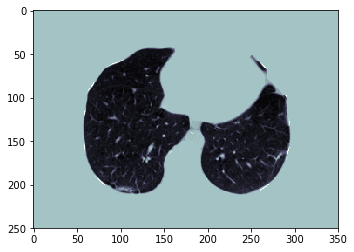

[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [5]:
def read_batch(batch_files):
    
    # do not account the placeholder zeros for the batch size
    current_batch_size = batch_size - np.sum(batch_files == '0')
    
    batch_features = np.zeros((current_batch_size, data_shape[0], data_shape[1], data_shape[2], 1))
    
    labels = []
    for i in range(len(batch_files)):
        if batch_files[i] != '0':
            data = np.load(preprocessed_data_folder + batch_files[i])
            batch_features[i,:,:,:,0] = data['data']
            labels.append(data['label'])
    
    # one-hot encoding
    batch_labels = one_hot_encode(labels)

    return batch_features, batch_labels

train_features_batch_sample, train_labels_batch_sample = read_batch(train_batches[0])

plt.imshow(train_features_batch_sample[0,:,:,100,0], cmap=plt.cm.bone)
plt.show()
print(train_labels_batch_sample)

## Building Neural Network
Here we use Tensorflow to build a 3D Convolutional Neural Network. First, we define the layers in the neural net.

### Convolutional Layer

In [6]:
def conv3d(tensor, n_outputs, ksize, stride):
    # tensor: input tensor to the layer
    # n_outputs: number of outputs for convolutional layer
    # ksize: kernel size for convolutional layer
    # stride: stride size for convolutional layer
    
    # weight and bias tensor for convolutional layer
    weight = tf.Variable(tf.truncated_normal([ksize,
                                              ksize,
                                              ksize,
                                              tensor.get_shape().as_list()[4],
                                              n_outputs],
                                              stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # convolutional layer
    tensor = tf.nn.conv3d(tensor,
                          weight,
                          strides = [1,stride,stride,stride,1],
                          padding = 'SAME')
    tensor = tf.nn.bias_add(tensor, bias)
    
    # activation layer
    tensor = tf.nn.relu(tensor)
    
    return tensor

### Max-pooling Layer

In [7]:
def maxpool(tensor, ksize, stride):
    # tensor: input tensor to the layer
    # ksize: kernel size for max-pooling layer
    # stride: stride size for max-pooling layer
    
    # max-pooling layer
    tensor = tf.nn.max_pool3d(tensor,
                              ksize = [1,ksize,ksize,ksize,1],
                              strides = [1,stride,stride,stride,1],
                              padding = 'SAME')
    
    return tensor

### Flatten Layer
A flatten layer is used to reshape a 5D tensor to a 2D tensor. The flattened layer would be the input of a fully-connected layer. 

In [8]:
def flatten(tensor):
    flattened_size = np.prod(tensor.get_shape().as_list()[1:])
    return tf.reshape(tensor, [-1, flattened_size])

### Fully-connected Layer

In [9]:
def fully_conn(tensor, n_outputs):
    # tensor: input 2D tensor to the layer
    # n_outputs: number of outputs of the fully-connected layer
    
    size = tensor.get_shape().as_list()[1]
    
    # weigth and bias tensor for the fully-connected layer
    weight = tf.Variable(tf.truncated_normal([size, n_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    tensor = tf.nn.bias_add(tensor, bias)
    
    # activation layer
    tensor = tf.nn.relu(tensor)
    
    return tensor

### Output Layer

In [10]:
def output(tensor, n_outputs):
    # tensor: input 2D tensor to the layer
    # n_outputs: number of outputs of the output layer
    
    size = tensor.get_shape().as_list()[1]
    
    # weigth and bias tensor for the output layer
    weight = tf.Variable(tf.truncated_normal([size, n_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # output layer
    tensor = tf.matmul(tensor, weight)
    tensor = tf.nn.bias_add(tensor, bias)
    
    return tensor

### Convolutional Neural Network Model

In [11]:
def conv_net(x, keep_prob):
    # x: placeholder tensor that holds the input
    # keep_prob: placeholder tensor for the dropout layer
    
    # convolutional and max-pooling layers
    x = maxpool(x, 2, 2) # applying a max-pooling layer first to reduce the memory usage
    
    conv1 = conv3d(x, 32, 5, 2)
    conv1 = maxpool(conv1, 2, 2)
    
    conv2 = conv3d(conv1, 64, 5, 2)
    conv2 = maxpool(conv2, 2, 2)

    conv3 = conv3d(conv2, 128, 5, 2)
    conv3 = maxpool(conv3, 2, 2)
    
    # flatten layer
    flat = flatten(conv3)
    
    # fully-connected layers
    fc1 = fully_conn(flat, 1024)
    fc2 = fully_conn(fc1, 256)
    fc3 = fully_conn(fc2, 64)
    
    # dropout layer
    dropout = tf.nn.dropout(fc3, keep_prob)
    
    # output layer
    y = output(dropout, 2)
    
    return y

### Building Network

In [12]:
tf.reset_default_graph()

# inputs
x = tf.placeholder(tf.float32, (None, data_shape[0], data_shape[1], data_shape[2], 1), name='x')
y = tf.placeholder(tf.float32, (None, 2), name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# convolutional neural network model
logits = conv_net(x, keep_prob)
logits = tf.identity(logits, name='logits') # name logits tensor

# cost function and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
optimizer = tf.train.AdamOptimizer().minimize(cost) # Adam gradient descent optimizer

# accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

### Training Network

In [13]:
def train_conv_net(session, optimizer, keep_probability, features_batch, labels_batch):
    session.run(optimizer, feed_dict={
        x: features_batch,
        y: labels_batch,
        keep_prob: keep_probability
    })

def stats(session, function, n_batch, set):
    # n_batch: number of batches used for  calculation
    if set == 'train':
        assert (n_batch <= train_batches.shape[0])
        batches = train_batches
    if set == 'valid':
        assert (n_batch <= valid_batches.shape[0])
        batches = valid_batches
    
    
    batch_indices = np.arange(batches.shape[0])
    shuffle(batch_indices) # randomize the order
    batch_indices = batch_indices[:n_batch] # only select the first n_batch batches
    
    total_stats = 0.
    total_size = 0.
    # loop over the selected set
    for batch_index in batch_indices:
        features, labels = read_batch(batches[batch_index])
        current_stats = session.run(function, feed_dict={
                                    x: features,
                                    y: labels,
                                    keep_prob: 1. # deactivate dropout layer
                                    })
        current_batch_size = batch_size - np.sum(batches[batch_index] == '0')
        total_stats += current_stats * current_batch_size
        total_size += current_batch_size
    
    return total_stats / total_size
    
        
        
# print out current training stats
def show_stats(session, cost, accuracy):
    # training loss
    loss = stats(session, cost, 200, 'train')
    
    # validation loss
    valid_loss = stats(session, cost, 50, 'valid')
    
    # validation accuracy
    valid_accuracy = stats(session, accuracy, 50, 'valid')
    
    print('Training Loss: {:>8.4f} Validation Loss: {:>8.4f} Validation Accuracy: {:.6f}'.format(
        loss, valid_loss, valid_accuracy))

In [15]:
# hyperparameters
epochs = 4
keep_probability = 0.7
model_save_path = './model1'

In [ ]:
# start training
with tf.Session() as sess:
    # initialization
    sess.run(tf.global_variables_initializer())
    
    # saver
    saver = tf.train.Saver()
    
    # training
    for epoch in range(epochs):
        # loop over training batches
        for batch_index in range(train_batches.shape[0]):
            features_batch, labels_batch = read_batch(train_batches[batch_index])
            train_conv_net(sess, optimizer, keep_probability, features_batch, labels_batch)
            print('Epoch {:>2}, Batch {:>3} '.format(epoch + 1, batch_index), end='\r')
        print('Epoch {:>2} '.format(epoch + 1), end='')
        show_stats(sess, cost, accuracy)
        # save model
        saver.save(sess, model_save_path + '_' + str(epoch))

Epoch  1  Batch 222 Training Loss:   0.6974 Validation Loss:   0.7259 Validation Accuracy: 0.726908
Epoch  2  Batch 222 Training Loss:   0.7247 Validation Loss:   0.8423 Validation Accuracy: 0.702811
Epoch  3  Batch 222 Training Loss:   0.6753 Validation Loss:   0.8059 Validation Accuracy: 0.710843
Epoch  4  Batch 222 Training Loss:   0.7014 Validation Loss:   0.8087 Validation Accuracy: 0.722892
